In [35]:
!pip install yfinance

import numpy as np

from utils import *

In [36]:
# Download VNINDEX data (Yahoo Finance)
ticker = "VNM"

vnindex = yf.download(ticker, start=DAMREY_START_DATE, end=DAMREY_END_DATE)
print(vnindex.columns)

# Extract 'Adj Close' or fallback to 'Close'
if isinstance(vnindex.columns, pd.MultiIndex):
    # Flatten MultiIndex columns
    vnindex.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in vnindex.columns]
    adj_col = [col for col in vnindex.columns if 'Adj Close' in col or 'Close' in col][0]
else:
    adj_col = 'Adj Close' if 'Adj Close' in vnindex.columns else 'Close'

vnindex = vnindex[[adj_col]].rename(columns={adj_col: 'VNINDEX'})
vnindex.index = pd.to_datetime(vnindex.index)

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'VNM'),
            (  'High', 'VNM'),
            (   'Low', 'VNM'),
            (  'Open', 'VNM'),
            ('Volume', 'VNM')],
           names=['Price', 'Ticker'])


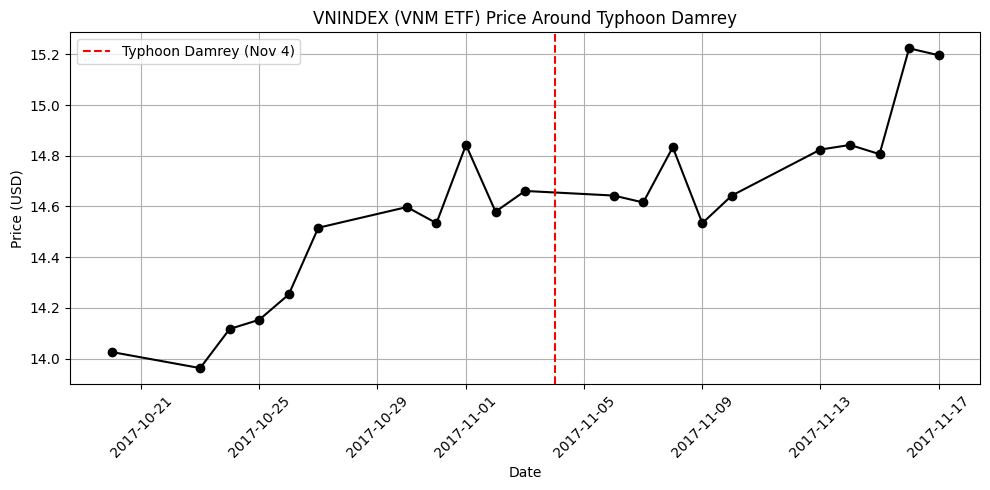

In [37]:
# Define event date: Typhoon Damrey landfall
# Landfall: November 4, 2017

# Market days +/- 15 days
event_window_dates = vnindex.loc[(vnindex.index >= DAMREY_DATE - timedelta(days=EVENT_WINDOW)) &
                                  (vnindex.index <= DAMREY_DATE + timedelta(days=EVENT_WINDOW))]

# Plot VNINDEX (VNM ETF) during the event window
plt.figure(figsize=(10, 5))
plt.plot(event_window_dates.index, event_window_dates['VNINDEX'], marker='o', color='black')
plt.axvline(event_date, color='red', linestyle='--', label='Typhoon Damrey (Nov 4)')
plt.title("VNINDEX (VNM ETF) Price Around Typhoon Damrey")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Abnormal Returns (AR)** tells how much a stock’s return deviates from “normal” on a given day. This is important to quantify because it isolates the effect of a specific event (e.g., Typhoon Damrey) from regular market movements. Here we're asking: Did something unusual happen to the stock because of this event?

* Normal return = what we would expect based on historical behavior (e.g., average return).

* AR$_t$ = Actual Return$_t$−Expected Return$_t$

In [38]:
# Calculate daily returns and abnormal returns
# The first row is expected to be NaN
vnindex['return'] = vnindex['VNINDEX'].pct_change()
mean_return = vnindex['return'].mean()
vnindex['abnormal_return'] = vnindex['return'] - mean_return
vnindex.head()

,VNINDEX,return,abnormal_return
Date,,,
2017-10-02,13.454502,NaN,NaN
2017-10-03,13.508938,0.004046,0.001584
2017-10-04,13.472650,-0.002686,-0.005148
2017-10-05,13.608734,0.010101,0.007639
2017-10-06,13.581517,-0.002000,-0.004462


**Cumulative Abnormal Return (CAR)** is the sum of abnormal returns over a window of days, usually around the event (e.g., -15 to +15 days).

CAR$_{[t_1,t_2]}$=$\sum_{t=t_1}^{t_2}$AR$_t$

This is an important quantity because it captures the total market impact of the event. A negative CAR suggests investors reacted negatively to the event, while a positive one suggests a favorable or resilient response.

              VNINDEX    return  abnormal_return       CAR
Date                                                      
2017-10-20  14.026072 -0.001937        -0.004399 -0.004399
2017-10-23  13.962562 -0.004528        -0.006990 -0.011389
2017-10-24  14.116794  0.011046         0.008584 -0.002805
2017-10-25  14.153088  0.002571         0.000109 -0.002696
2017-10-26  14.252883  0.007051         0.004589  0.001893


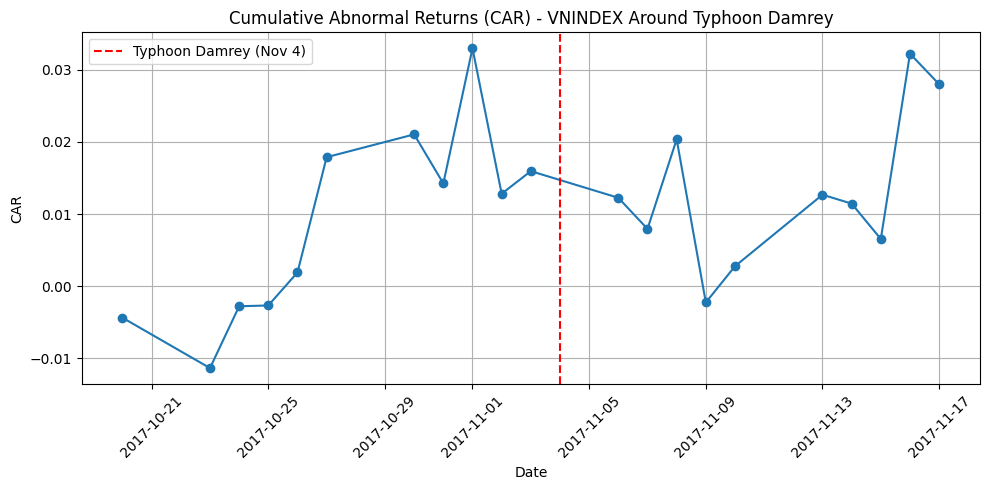

In [39]:
# Extract event window data
window_data = vnindex.loc[event_window_dates.index]
window_data['CAR'] = window_data['abnormal_return'].cumsum()
print(window_data.head())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(window_data.index, window_data['CAR'], marker='o')
plt.axvline(event_date, color='red', linestyle='--', label='Typhoon Damrey (Nov 4)')
plt.title("Cumulative Abnormal Returns (CAR) - VNINDEX Around Typhoon Damrey")
plt.xlabel("Date")
plt.ylabel("CAR")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There's no clear significant behaviour that points to an obvious downturn of the market. We'll explore specific sectors.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


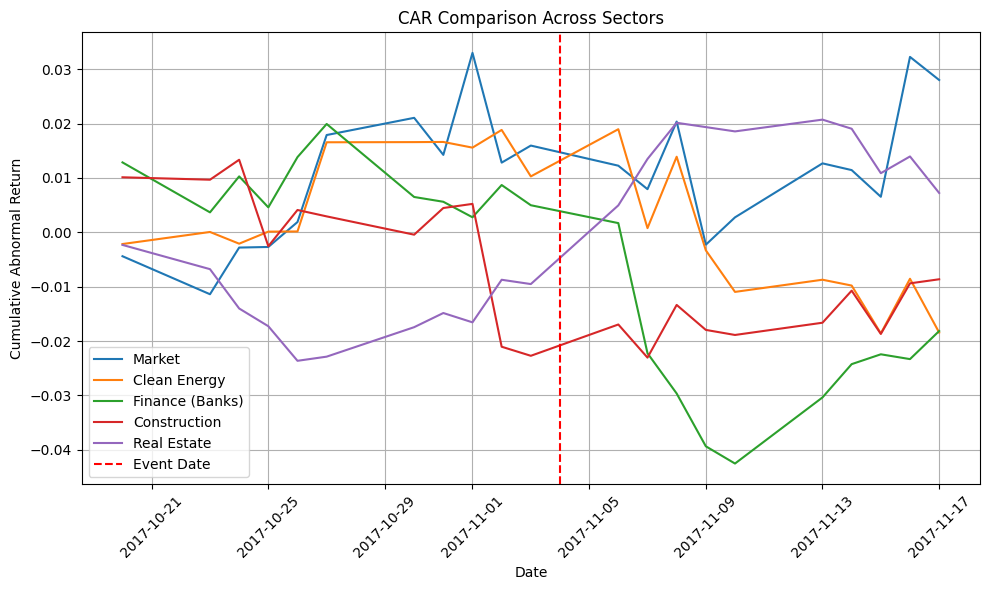

In [44]:
# Sector Comparison CAR
# Testing with other global sectors -- not much available info for Vietnam.

sector_tickers = {
    "VNM": "Market",                # Vietnam ETF (broad market)
    "ICLN": "Clean Energy",         # iShares Global Clean Energy
    "KBE": "Finance (Banks)",       # US bank ETF, proxy
    "XHB": "Construction",          # Homebuilders ETF
    "XLRE": "Real Estate",          # US real estate sector ETF
}

sector_results = compute_sector_cars(sector_tickers, DAMREY_START_DATE, DAMREY_END_DATE, DAMREY_DATE)
plot_car_comparison(sector_results, event_date)

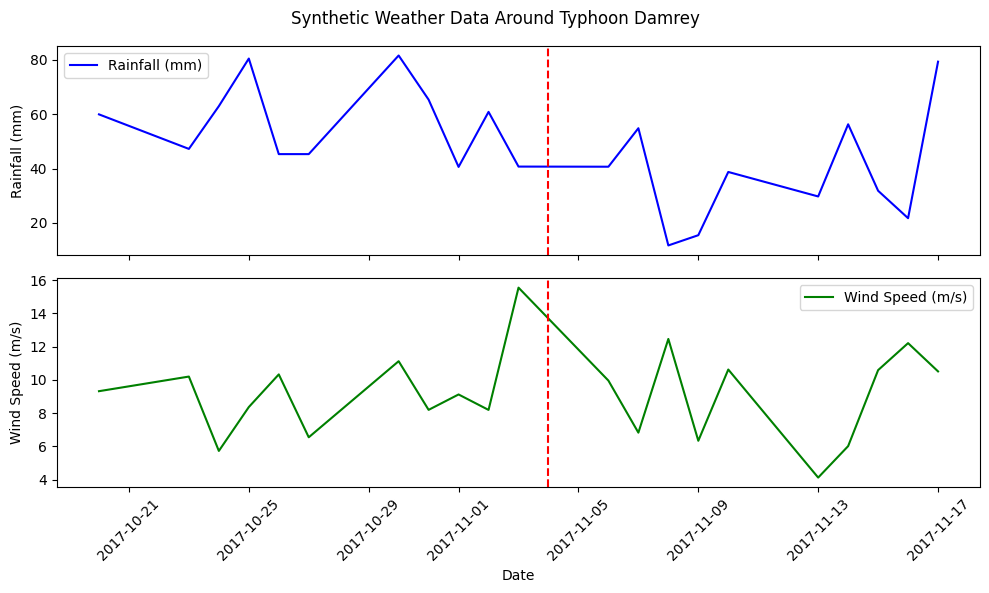

In [45]:
# Add synthetic climate data for demonstration
np.random.seed(42)
window_data['rainfall_mm'] = np.random.normal(loc=50, scale=20, size=len(window_data))
window_data['wind_speed'] = np.random.normal(loc=10, scale=3, size=len(window_data))

# Plot climate variables
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(window_data.index, window_data['rainfall_mm'], label='Rainfall (mm)', color='blue')
ax[0].axvline(event_date, color='red', linestyle='--')
ax[0].set_ylabel("Rainfall (mm)")
ax[0].legend()

ax[1].plot(window_data.index, window_data['wind_speed'], label='Wind Speed (m/s)', color='green')
ax[1].axvline(event_date, color='red', linestyle='--')
ax[1].set_ylabel("Wind Speed (m/s)")
ax[1].set_xlabel("Date")
ax[1].legend()

plt.suptitle("Synthetic Weather Data Around Typhoon Damrey")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()